## Formulation
Lets say you have two vector valued random variables $x$ and $y$ with some joint density $p(x,y)$.  Assume you can generate samples of $(x,y)$.

Let $r_i^{(k)}$ denote component $i$ of the random variable $r$ in layer $k$ of the normalizing flow.   Using a RealNVP approach, each layer of the transformation takes the form
$$
\left[\begin{array}{c}r_{0:d}^{(k+1)}\\ r_{d+1:D}^{(k+1)} \end{array}\right] = P\left[\begin{array}{c}r_{0:d}^{(k)}\\ b\left(r_{0:d}^{(k)}\right) + s\left(r_{0:d}^{(k)}\right)r_{d+1:D}^{(k)} \end{array}\right],
$$
where $P$ is a permutation matrix.

In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import h5py
import random


from Models.NVP import NVP
from Probability.Distributions import RotatedBanana
from Probability.MCMC import MH2d

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
file = h5py.File('BeamSamples.h5','r')
target_samples = tf.constant(np.array(file['/Samples']),dtype=tf.float32)[::5,:]
#target_samples columns in form x,y where x are parameters and y are observations 
N_samples, latent_dim = target_samples.shape[:]
n_obs = 6
n_params = latent_dim - n_obs
X = target_samples[...,:n_params]
Y = target_samples[...,n_params:]
YX = tf.concat([Y,X],axis=-1)

# Define training options
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(YX)
dataset = dataset.shuffle(buffer_size=N_samples).batch(batch_size)

### Define an NVP-based normalizing flow

In [3]:
# Create model object
num_layers = 8
permutations = []
y_permutations = list(np.arange(n_obs))
x_permutations = list(np.arange(n_obs,latent_dim))
for i in range(num_layers):
    random.shuffle(x_permutations)
    permutations.append(y_permutations+x_permutations)

nvp = NVP(num_masked=8, output_dim=latent_dim, num_layers=num_layers, neuron_list=[100,100], permutations=permutations)
# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=5e-4, epsilon=1e-06)
nvp.compile(opt)
# Perform a forward pass to initialize variables
_ = nvp(tf.random.normal([1,latent_dim]))
nvp.summary()

Model: "NVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 89,742
Trainable params: 89,742
Non-trainable params: 0
_________________________________________________________________


### Train the model using ADAM

In [4]:
# Train the model with the new callback
n_epochs = 50
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training
# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/50
200/200 [==============================] - 6s 32ms/step - Negative Log Likelihood: -10.7981
Epoch 2/50
200/200 [==============================] - 6s 32ms/step - Negative Log Likelihood: -11.5262
Epoch 3/50
200/200 [==============================] - 6s 31ms/step - Negative Log Likelihood: -11.7598
Epoch 4/50
200/200 [==============================] - 6s 30ms/step - Negative Log Likelihood: -11.8556
Epoch 5/50
200/200 [==============================] - 6s 30ms/step - Negative Log Likelihood: -11.8895
Epoch 6/50
200/200 [==============================] - 6s 30ms/step - Negative Log Likelihood: -12.0553
Epoch 7/50
200/200 [==============================] - 6s 31ms/step - Negative Log Likelihood: -12.0700
Epoch 8/50
200/200 [==============================] - 6s 31ms/step - Negative Log Likelihood: -12.1253
Epoch 9/50
200/200 [==============================] - 6s 32ms/step - Negative Log Likelihood: -12.1688
Epoch 10/50
200/200 [==============================] - 6s 31ms/step - Neg

### Plot the training history

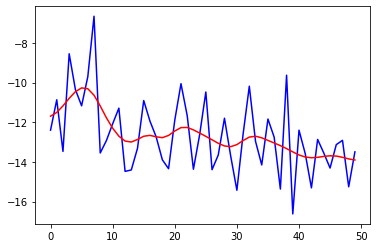

In [5]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(history.history['Negative Log Likelihood'],'b')
plt.plot(ysmoothed, color = 'r')

## Sampling $p(x|y)$ using triangular structure

In [8]:
# We want to draw condition samples from about y = y^*
N_cond_samps = 1000
y_star = tf.reshape(Y[0],[-1,n_obs])

ref_samps = tf.random.normal([N_cond_samps,latent_dim])
tgt_samps = nvp(ref_samps)

# Figure out what the value of r1 is
tgt_test = tf.concat([y_star, tgt_samps[0:1,n_obs:]], axis=1)
r1 = nvp.inverse(tgt_test)[0,:n_obs]

# Now generate samples using the normalizing flow and fixed value of r1
cond_ref_samps = tf.concat([r1*tf.ones([N_cond_samps,n_obs]), tf.random.normal([N_cond_samps,n_params])], axis=-1)
cond_tgt_samps = nvp(cond_ref_samps)
cond_x = cond_tgt_samps[:,n_obs:]

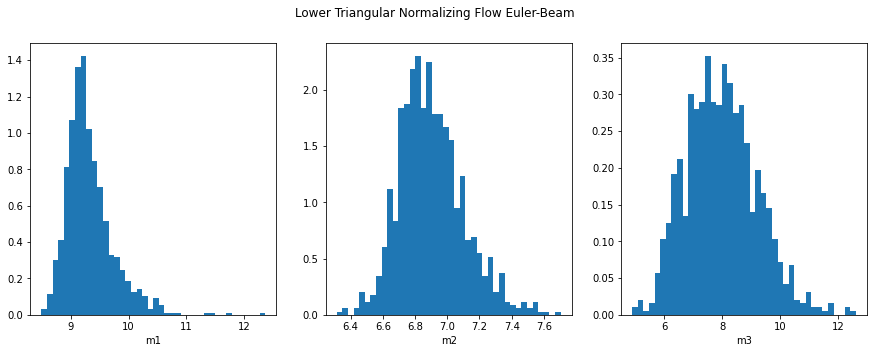

In [10]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
N_bins = 40
ax[0].hist(cond_x[:,0],N_bins,density=True)
ax[0].set(xlabel='m1')
ax[1].hist(cond_x[:,1],N_bins,density=True)
ax[1].set(xlabel='m2')
ax[2].hist(cond_x[:,2],N_bins,density=True)
ax[2].set(xlabel='m3')
fig.suptitle('Lower Triangular Normalizing Flow Euler-Beam')
#plt.savefig('LTNF_Euler_Beam_samples.png')